# Set-up
- **Goal**: to provide a solution (a classification model) for optimizing search engine relevance.

# 1. EADS/Preprocessing

## 1.1 Overview

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 0 # Seed for randomization 
IMG_PATH = 'img/'

In [2]:
df = pd.read_csv('Dataset Attachment A.csv')

In [3]:
df.head(5)

,query_id,url_id,query_length,is_homepage,sig1,sig2,sig3,sig4,sig5,sig6,sig7,sig8,relevance
0,4631,28624,2,1,0.09,0.15,1288,352,376,13,0.46,0.35,0
1,4631,28625,2,1,0.20,0.35,4662,337,666,28,0.43,0.27,1
2,4631,28626,2,1,0.36,0.49,1121,385,270,15,0.34,0.20,1
3,4631,28627,2,1,0.21,0.45,2925,478,640,14,0.44,0.33,1
4,4631,28628,2,1,0.25,0.42,1328,429,412,27,0.40,0.57,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80046 entries, 0 to 80045
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   query_id      80046 non-null  int64  
 1   url_id        80046 non-null  int64  
 2   query_length  80046 non-null  int64  
 3   is_homepage   80046 non-null  int64  
 4   sig1          80046 non-null  float64
 5   sig2          80046 non-null  float64
 6   sig3          80046 non-null  int64  
 7   sig4          80046 non-null  int64  
 8   sig5          80046 non-null  int64  
 9   sig6          80046 non-null  int64  
 10  sig7          80046 non-null  float64
 11  sig8          80046 non-null  float64
 12  relevance     80046 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 7.9 MB


- 80046 observations (responses)
- Target: `relevance`. Whether the search result is relevant or not. 
- 12 Features: `query_id`, `url_id`, `query_length`, `is_homepage`, `sig1`, `sig2`, `sig3`, `sig4`, `sig5`, `sig6`, `sig7`, `sig8`

In [5]:
X = df.drop('relevance', axis=1)
y = df['relevance']

### 1.1.1 Missing values
- Data is complete.

### 1.1.2 Data types
- Target is a binary variable with values {0, 1}.
- Of the 12 features, 8 are discrete and 4 are continuous.
    - Note that `query_id`, `url_id`, `is_homepage` should be categorical. Yet, we will leave the data types as integer for convenience.

In [6]:
data_types = X.dtypes.value_counts().reset_index().rename(columns={'index':'data_type', 0:'count'})
data_types

,data_type,count
0,int64,8
1,float64,4


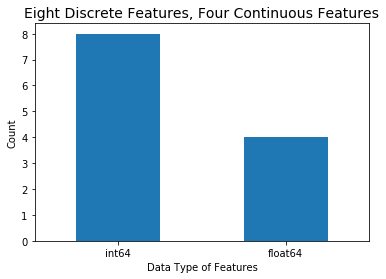

In [7]:
_ = data_types.plot.bar(x='data_type', y='count', rot=0, legend=None)
_ = plt.title('Eight Discrete Features, Four Continuous Features', fontsize=14)
_ = plt.xlabel('Data Type of Features')
_ = plt.ylabel('Count')
plt.savefig(IMG_PATH + '1.1.2.1.png')

- We will also examine the number of unique values for each feature.

In [8]:
n_unique = X.nunique().reset_index().rename(
    columns={'index':'feature', 0:'n_unique'}).sort_values(by='n_unique', 
                                                           ascending=False)
n_unique['perc_unique'] = n_unique['n_unique'] / len(X)
n_unique['data_type'] = n_unique.apply(lambda x: X.dtypes[x['feature']], axis=1)

In [9]:
n_unique

,feature,n_unique,perc_unique,data_type
1,url_id,75231,0.939847,int64
6,sig3,14209,0.177510,int64
0,query_id,12408,0.155011,int64
7,sig4,4404,0.055018,int64
8,sig5,3583,0.044762,int64
9,sig6,767,0.009582,int64
4,sig1,101,0.001262,float64
11,sig8,95,0.001187,float64
10,sig7,87,0.001087,float64
5,sig2,85,0.001062,float64


- Observe that `url_id` and `query_id` are not unique. 
- For `url_id`, almost 94% of the category is unique. Therefore, we will **remove** this feature before modeling as it is not so informative.

## 1.2 Exploratory Data Analysis

### 1.2.1 Univariate
#### (1) Target: `relevance`

In [10]:
print('Counts of label 0:', y.value_counts()[0])
print('Counts of label 1:', y.value_counts()[1])

Counts of label 0: 45059
Counts of label 1: 34987


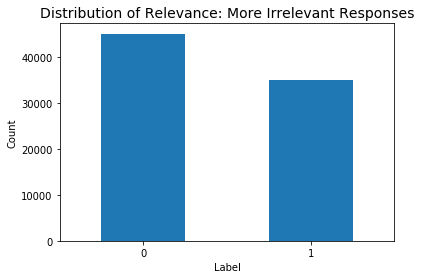

In [11]:
_ = y.value_counts().plot(kind='bar', rot=0)
_ = plt.title('Distribution of Relevance: More Irrelevant Responses', fontsize=14)
_ = plt.xlabel('Label')
_ = plt.ylabel('Count')
plt.savefig(IMG_PATH + '1.2.1.1.png')

- There are 45059 irrelevant responses and 34987 relevant responses. We will need to deal with class imbalance before modeling.

#### (2) Categorical Features
- We will examine the distributions of `url_id`, `query_id` and `is_homepage`.
- Due to the high cardinality of `url_id` and `query_id`, we will plot the histograms to get a sense of the distribution. Nevertheless, this is not a norm of exploring categorical variables.

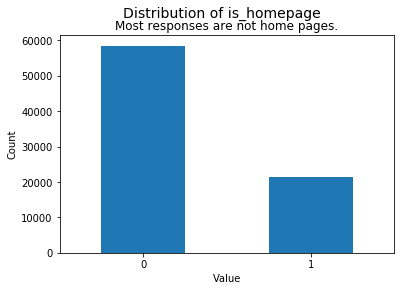

In [12]:
_ = X['is_homepage'].value_counts().plot(kind='bar', rot=0)
_ = plt.xlabel('Value')
_ = plt.ylabel('Count')
_ = plt.suptitle('Distribution of is_homepage', fontsize=14)
_ = plt.title('Most responses are not home pages.')
plt.savefig(IMG_PATH + '1.2.1.2.1.png')

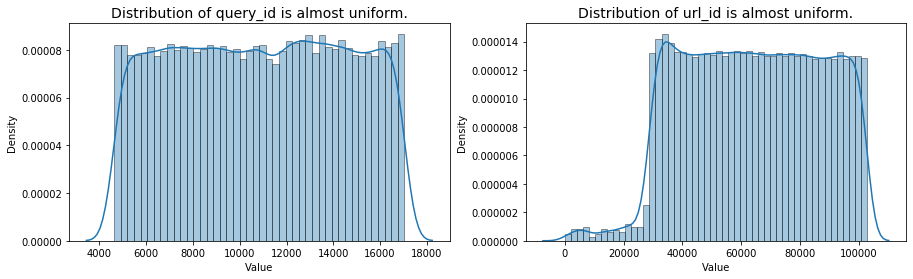

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

for i, var in enumerate(['query_id', 'url_id']):
    sns.distplot(X[var], hist=True, kde=True, ax=axes[i], hist_kws={'edgecolor':'black'})
    _ = axes[i].set_title('Distribution of ' + var + ' is almost uniform.', fontsize=14) 
    _ = axes[i].set_xlabel('Value')
    _ = axes[i].set_ylabel('Density')
plt.savefig(IMG_PATH + '1.2.1.2.2.png')

#### (3) Continuous Features
- We will examine the distributions of each feature along with their summary statistics.

In [14]:
X_cont = X.select_dtypes(include='float64')

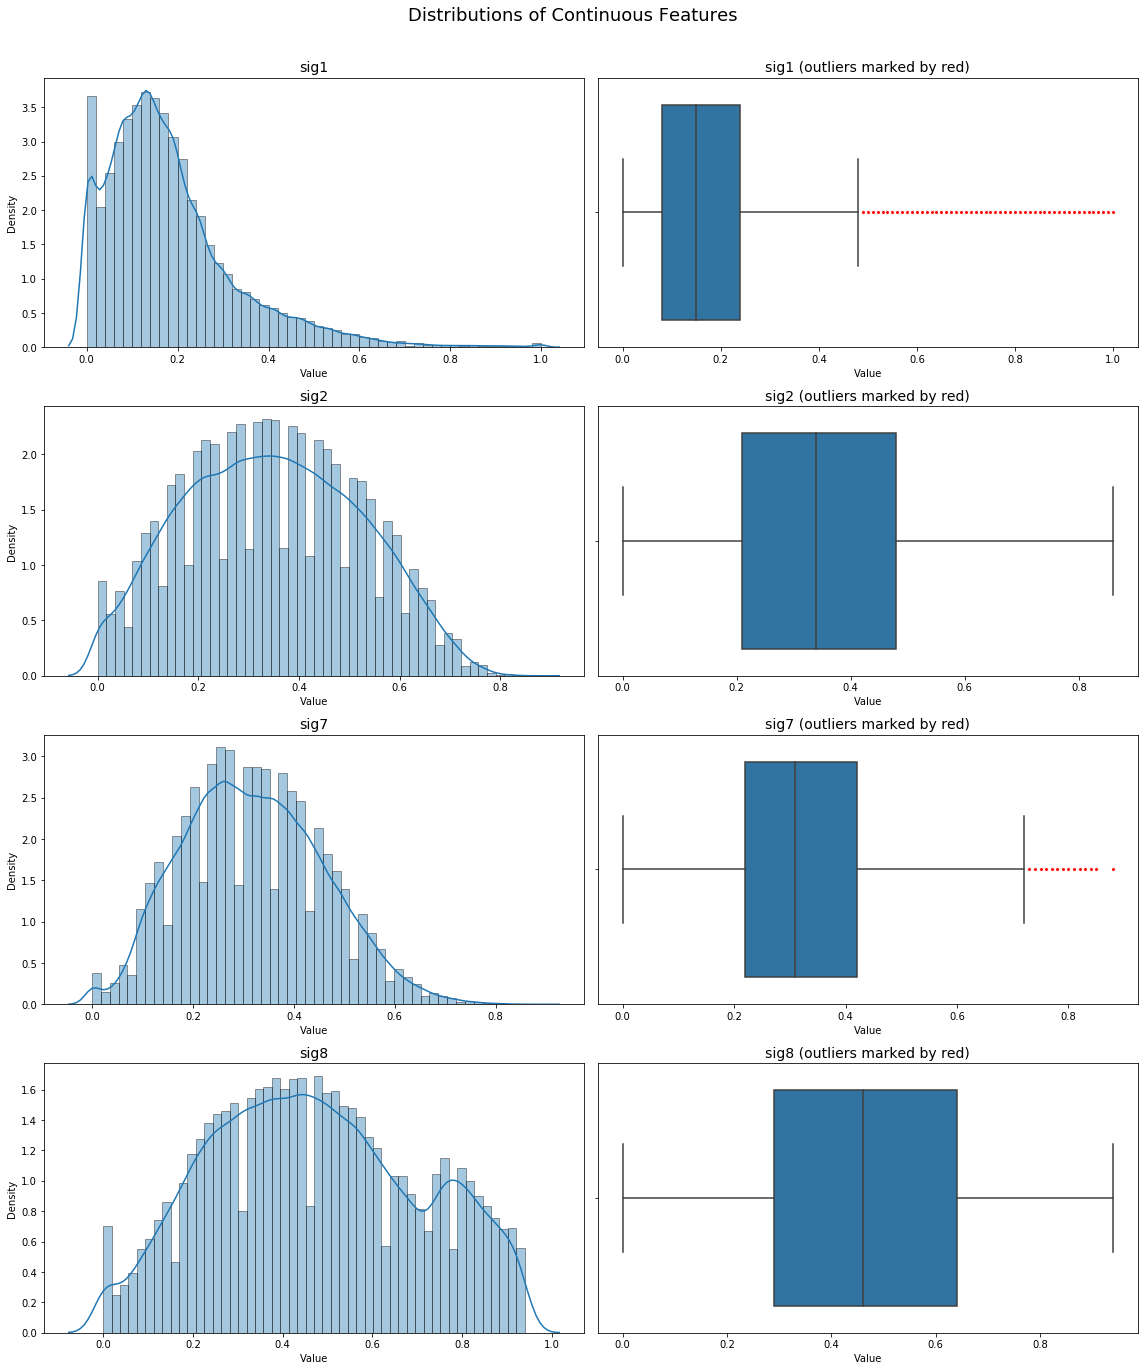

In [15]:
fig = plt.figure(figsize=(16, 20))

for i, var in enumerate(np.repeat(X_cont.columns, 2)):
    ax = fig.add_subplot(4, 2, i+1) 
    if i % 2 == 0:
        sns.distplot(X_cont[var], hist=True, kde=True, ax=ax, 
                     hist_kws={'edgecolor':'black'},)
        _ = ax.set_title(var, fontsize=14) 
        _ = ax.set_xlabel('Value')
        _ = ax.set_ylabel('Density')
    else:
        sns.boxplot(X_cont[var], 
                    flierprops = dict(marker='o', markerfacecolor='red', 
                                      markersize=4, markeredgecolor='white'))
        _ = ax.set_title(var + ' (outliers marked by red)', fontsize=14)
        _ = ax.set_xlabel('Value')
plt.suptitle('Distributions of Continuous Features', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(IMG_PATH + '1.2.1.3.png')

In [16]:
X_cont_summary = pd.concat([X_cont.describe(), X_cont.mode()])
X_cont_summary.rename(index={0: 'mode'}, inplace=True)
X_cont_summary

,sig1,sig2,sig7,sig8
count,80046.000000,80046.000000,80046.000000,80046.000000
mean,0.183240,0.346947,0.319464,0.471846
std,0.147354,0.172545,0.138651,0.231306
min,0.000000,0.000000,0.000000,0.000000
25%,0.080000,0.210000,0.220000,0.290000
50%,0.150000,0.340000,0.310000,0.460000
75%,0.240000,0.480000,0.420000,0.640000
max,1.000000,0.860000,0.880000,0.940000
mode,0.000000,0.320000,0.260000,0.470000


- Shape of distributions
    - `sig1`: right-skewed. Mode occurs at 0. Outliers spotted.
    - `sig2`: roughly symmetric.
    - `sig7`: slightly right-skewed. Outliers spotted.
    - `sig8`: roughly symmetric, bi-modal.
- Notice the gaps of bars for `sig2`, `sig7` and `sig8`, where certain values have less counts than surrounding values.

#### (4) Discrete Features
- We will examine the distributions of each feature along with their summary statistics. 
    - Due to cardinalities, we will plot bar chart for `query_length` and histograms/boxplots for the others.

In [17]:
X_discrete = X.select_dtypes(include='int64')
X_discrete = X_discrete.drop(['is_homepage', 'url_id', 'query_id'], axis=1)

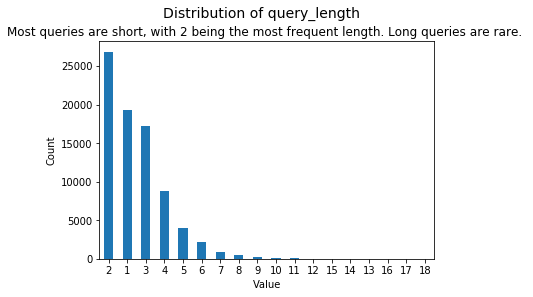

In [18]:
_ = X['query_length'].value_counts().plot(kind='bar', rot=0)
_ = plt.xlabel('Value')
_ = plt.ylabel('Count')
_ = plt.suptitle('Distribution of query_length', fontsize=14, y=1)
_ = plt.title('Most queries are short, with 2 being the most frequent length. Long queries are rare. ')
plt.savefig(IMG_PATH + '1.2.1.4.1.png')

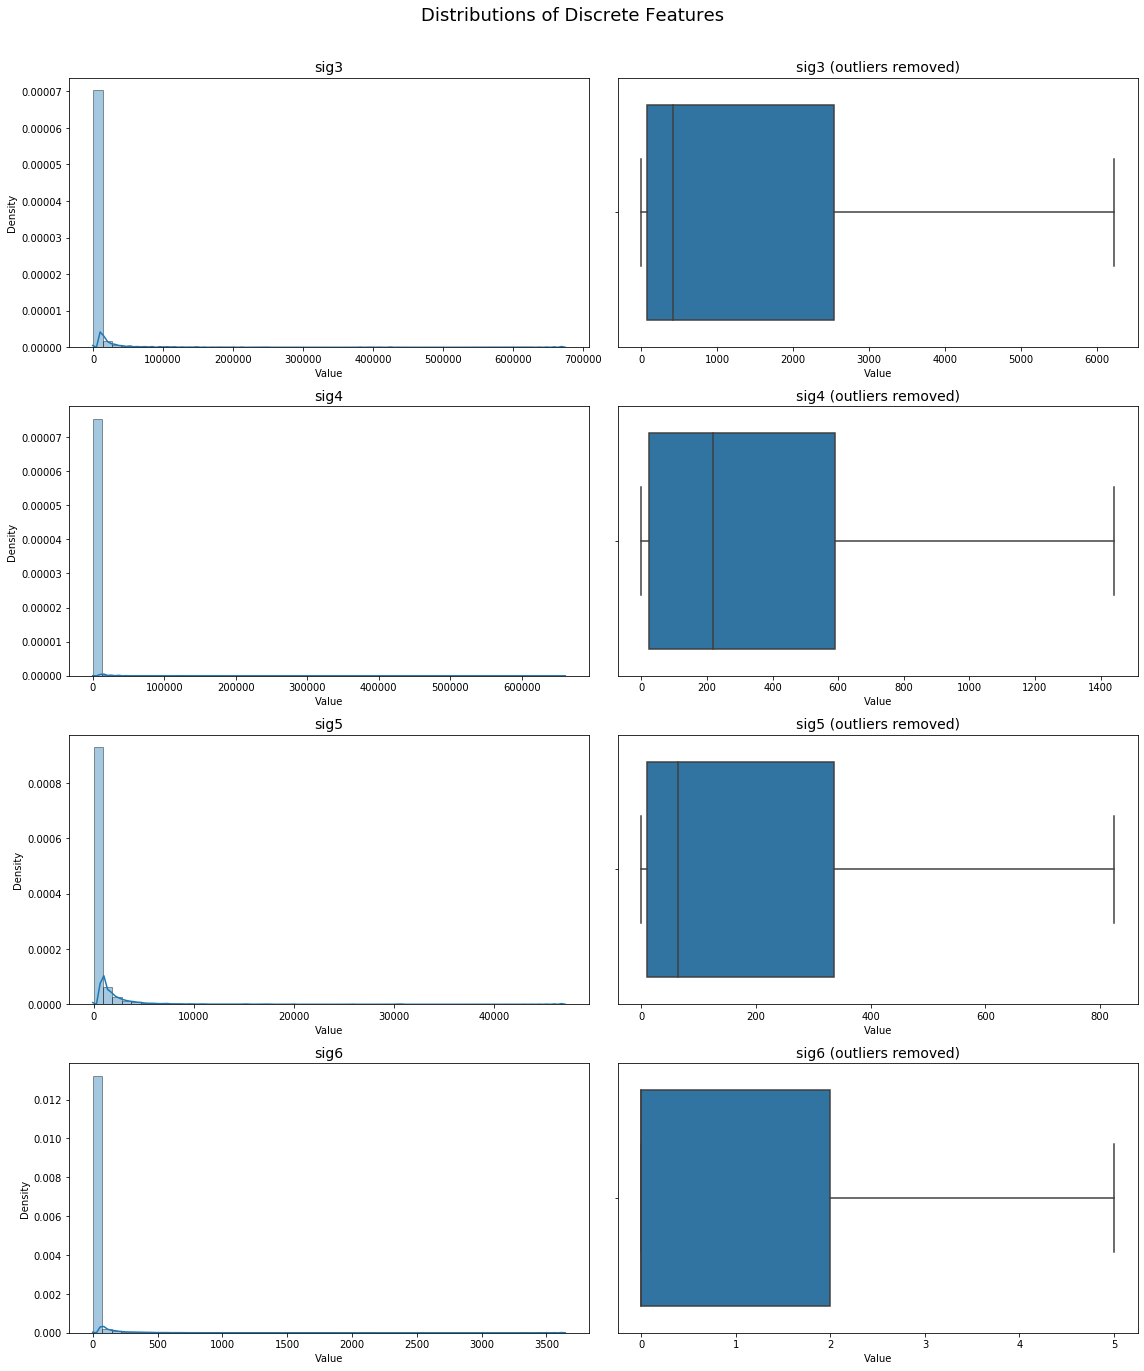

In [19]:
discrete_sig = X_discrete.drop(['query_length'], axis=1)
fig = plt.figure(figsize=(16, 20))


for i, var in enumerate(np.repeat(discrete_sig.columns, 2)):
    ax = fig.add_subplot(4, 2, i+1) 
    if i % 2 == 0:
        sns.distplot(X_discrete[var], hist=True, kde=True, ax=ax,
                     hist_kws={'edgecolor':'black'})
        _ = ax.set_title(var, fontsize=14) 
        _ = ax.set_xlabel('Value')
        _ = ax.set_ylabel('Density')
    else:
        sns.boxplot(X_discrete[var], showfliers=False)
        _ = ax.set_title(var + ' (outliers removed)', fontsize=14)
        _ = ax.set_xlabel('Value')

plt.suptitle('Distributions of Discrete Features', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(IMG_PATH + '1.2.1.4.2.png')

In [20]:
X_discrete_summary = pd.concat([X_discrete.describe(), X_discrete.mode()])
X_discrete_summary.rename(index={0: 'mode'}, inplace=True)
X_discrete_summary

,query_length,sig3,sig4,sig5,sig6
count,80046.000000,80046.000000,80046.000000,80046.000000,80046.000000
mean,2.585826,4857.078555,742.316256,550.527597,14.099155
std,1.522094,23531.973200,4818.359126,1887.933968,90.068426
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,78.000000,24.000000,10.000000,0.000000
50%,2.000000,417.000000,220.000000,64.000000,0.000000
75%,3.000000,2537.750000,591.000000,336.000000,2.000000
max,18.000000,673637.000000,660939.000000,46994.000000,3645.000000
mode,2.000000,0.000000,0.000000,0.000000,0.000000


- The scales for the discrete features vary a lot. We will need to scale the features before modeling.
- Significant outliers are present along with a majority class of points with very small values.

### 1.2.2 Multivariate

#### (1) Correlations

In [21]:
def corr_heatmap(df, figsize=10):
    
    corr = df.corr()

    plt.figure(figsize=(figsize, figsize))
    plt.title('Correlations', fontsize=14)

    ax = sns.heatmap(corr,
                     cmap='coolwarm', 
                     square=True,
                     annot=True)
    plt.tight_layout()

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    plt.savefig(IMG_PATH + '1.2.2.1.png')

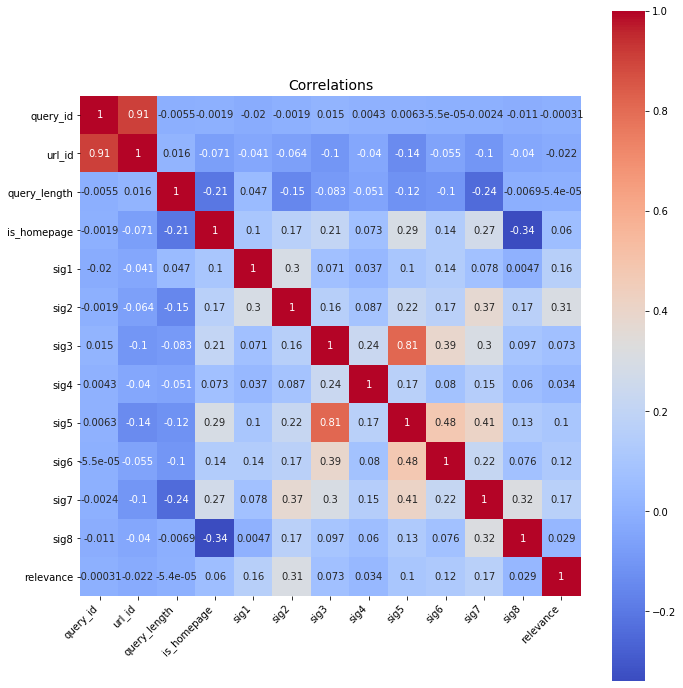

In [22]:
corr_heatmap(df)

- From the heatmap,
    - Target vs. Features
        - Correlations between `relevance` and (1) `query_length` (2) `query_id` are weak, indicating that `relevance` is not so affected by query ID (reasonable as IDs are usually just identifiers not relevant for the classification task) or the length of the input query.
        - `sig2` appears to be the most associated feature with `relevance`.
    - Multicollinearity is spotted for certain features. 
        - We will explore this later. Let's first take a closer look at the target vs. features.

#### (2) `relevance` vs. continuous features

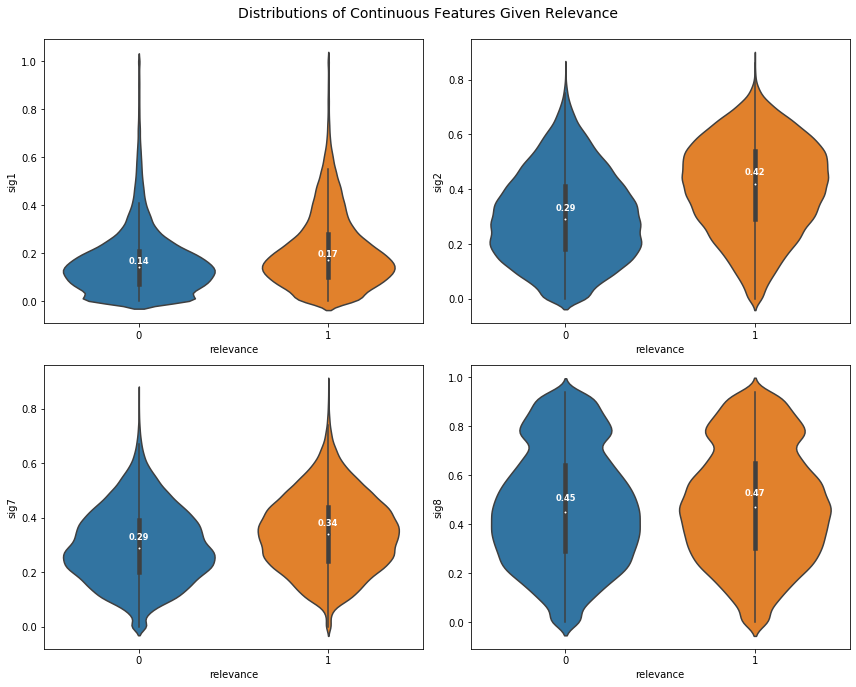

In [23]:
fig = plt.figure(figsize=(12, 10))

for i, var in enumerate(X_cont):
    ax = fig.add_subplot(2, 2, i+1) 
    v_plot = sns.violinplot(x='relevance', y=var, data=df, ax=ax)
    
    # Annotation for medians
    medians = df.groupby(['relevance'])[var].median()
    vertical_offset = df[var].median() * 0.1 # offset from median for display

    for xtick in v_plot.get_xticks():
        v_plot.text(xtick, medians[xtick] + vertical_offset, medians[xtick], 
                    horizontalalignment='center', size='small', color='w', weight='semibold')

plt.suptitle('Distributions of Continuous Features Given Relevance', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(IMG_PATH + '1.2.2.2.png')

- Distributions of `sig1`, `sig7` and `sig8` are almost the same for both classes of `relevance`. 
- `sig2` has a slightly right-skewed distribution of irrelevant responses, but a slightly left-skewed distribution for relevant ones.
- This confirms the previous result that `sig2` has a significantly higher correlation with `relevance` than other features.

#### (3) `relevance` vs. `is_homepage`
- For relevant responses, there seems to be larger portion of homepage responses as compared to that in irrelevant responses.

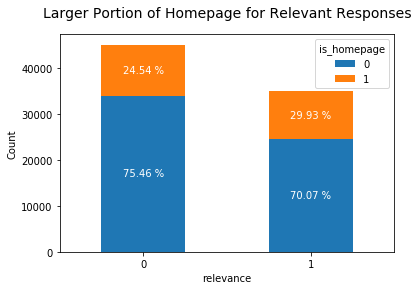

In [24]:
pivot_df = df.pivot_table(index='relevance', columns='is_homepage', aggfunc='size')
ax = pivot_df.plot(kind='bar', stacked=True, rot=0)

# Annotate percentage
for i, p in enumerate(ax.patches):
    width, height = p.get_width(), p.get_height()
    _x, _y = p.get_xy() 
    size = np.sum(y == 0) if i % 2 == 0 else np.sum(y == 1)
    ax.text(_x+width/2, 
            _y+height/2, 
            '{:.2f} %'.format(100*(height/size)), 
            color='w',
            horizontalalignment='center', 
            verticalalignment='center')

_ = plt.title('Larger Portion of Homepage for Relevant Responses', fontsize=14, y=1.05)
_ = plt.ylabel('Count')
plt.savefig(IMG_PATH + '1.2.2.3.png')

#### (4) `relevance` vs. discrete features other than `query_length`

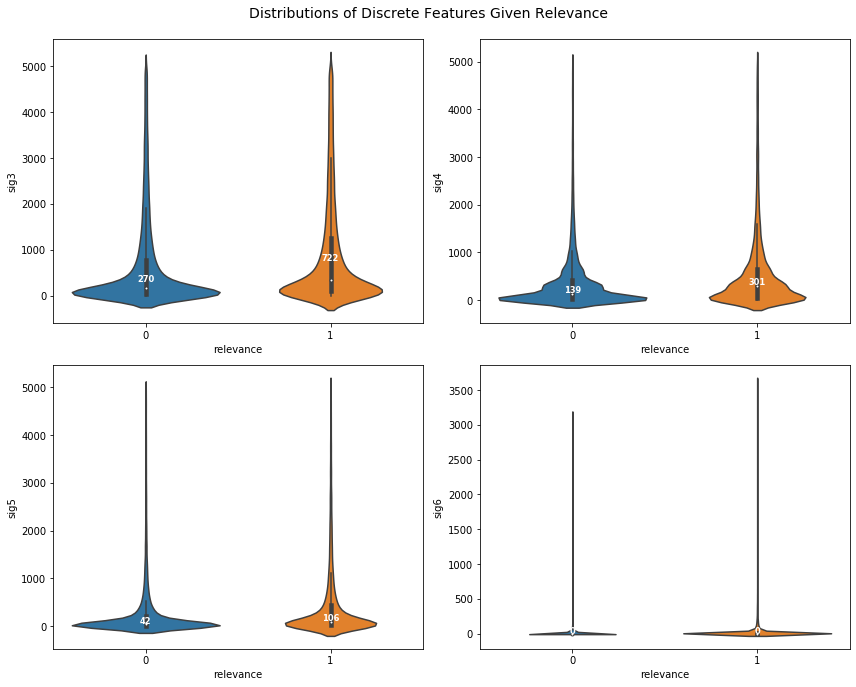

In [25]:
fig = plt.figure(figsize=(12, 10))

for i, var in enumerate(discrete_sig.columns):
    ax = fig.add_subplot(2, 2, i+1) 
    v_plot = sns.violinplot(x='relevance', y=var, data=df[df[var] < 5000], ax=ax)
    
    # Annotation for medians
    medians = df.groupby(['relevance'])[var].median()
    vertical_offset = df[var].median() * 0.1 # offset from median for display

    for xtick in v_plot.get_xticks():
        v_plot.text(xtick, medians[xtick] + vertical_offset, medians[xtick], 
                    horizontalalignment='center', size='small', color='w', weight='semibold')

plt.suptitle('Distributions of Discrete Features Given Relevance', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(IMG_PATH + '1.2.2.4.png')

- We will remove the long tails for better visualization. Observe that
    - Distributions of `relevance` for each feature at 0 vary.

#### (5) Multicollinearity

In [26]:
def pairplot(df, figsize=14):
    fig = plt.figure(figsize=(figsize, figsize))
    res = pd.DataFrame(columns=['feature_a', 'feature_b', 'corr_strength', 'corr'])
    
    corr = df.corr()
    i, k = 0, 0
    while i < df.shape[1] - 1: # Exclude the target
        j = i + 1
        while j < df.shape[1] - 1:
            if abs(corr.iloc[i, j]) > 0.3:
                corr_strength = 'strong' if abs(corr.iloc[i, j]) > 0.7 else 'moderate'
                # Append a row to the result table
                series = pd.Series([corr.columns[i], corr.columns[j], corr_strength, 
                                    round(corr.iloc[i, j], 2)],index=res.columns) 
                res = res.append(series, ignore_index=True)
                
                # Plot scatterplot, hued by relevance
                ax = fig.add_subplot(3, 3, k+1) 
                sns.scatterplot(x=corr.columns[i], y=corr.columns[j], 
                                hue='relevance', data=df, ax=ax, alpha=0.7)
                ax.set_xlabel(corr.columns[i])
                ax.set_ylabel(corr.columns[j])
                k += 1
            j += 1
        i += 1 
    
    plt.suptitle('Pairplot of Correlated Features', fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.savefig(IMG_PATH + '1.2.2.5.png')
    return res

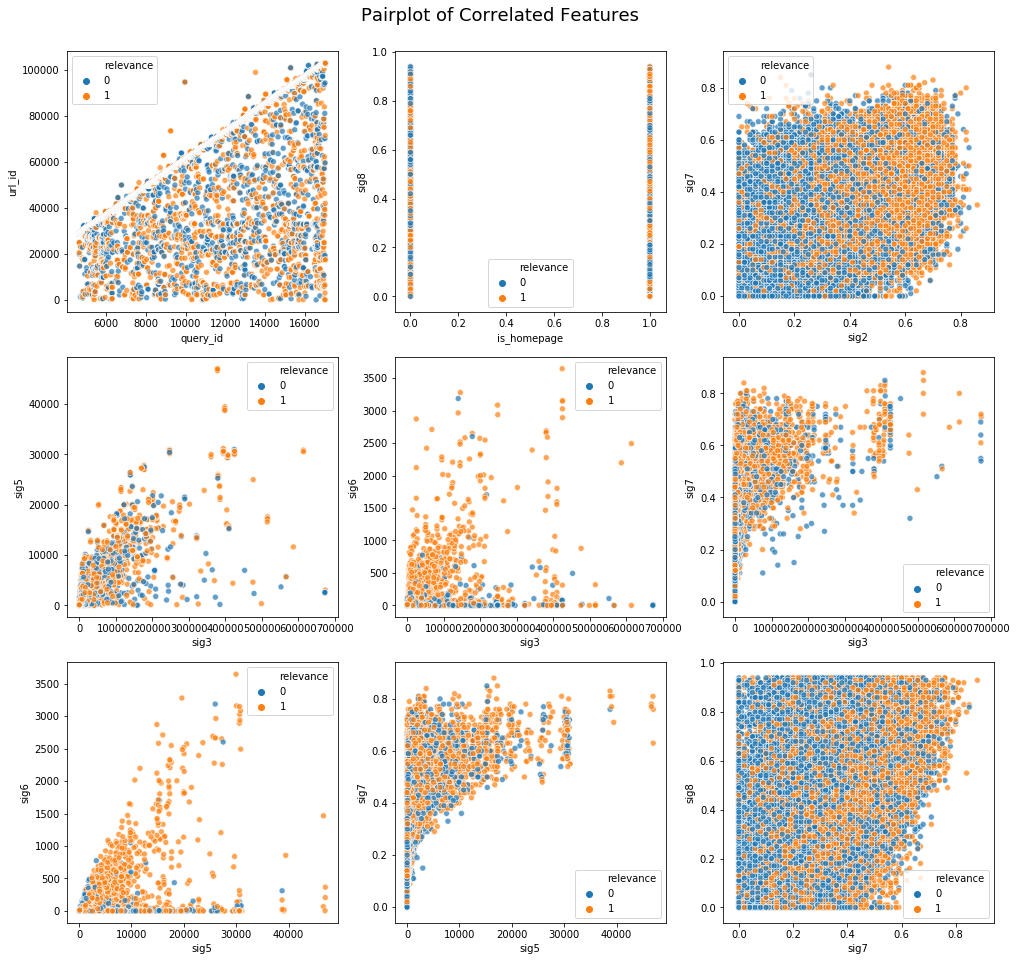

In [27]:
res = pairplot(df)

In [28]:
res.sort_values(by='corr', ascending=False)

,feature_a,feature_b,corr_strength,corr
0,query_id,url_id,strong,0.91
3,sig3,sig5,strong,0.81
6,sig5,sig6,moderate,0.48
7,sig5,sig7,moderate,0.41
4,sig3,sig6,moderate,0.39
2,sig2,sig7,moderate,0.37
8,sig7,sig8,moderate,0.32
5,sig3,sig7,moderate,0.30
1,is_homepage,sig8,moderate,-0.34


- Strong positive correlations exist between the following features, meaning that as one of the features increases, the other is highly likely to increase as well.
    - `query_id` and `url_id`
        -  The positive correlation is reasonable since the identifiers are usually generated incrementally in parallel.
    - `sig3` and `sig5`
- Moderate correlations exist between the following features.
    - `is_homepage` and `sig8`
    - `sig2` and `sig7`
    - `sig3` and `sig6`/`sig7`
    - `sig5` and `sig6`/`sig7`
    - `sig7` and `sig8`
- We are not so worried about the moderate correlations. However, we would like to take care of the most strongly correlated features with `corr=0.91`, deciding whether to remove one of the pair to avoid redundant information. 

### 1.2.3 A Note on Outliers

In [29]:
from scipy.stats import zscore

z_score = np.abs(zscore(df))
df_no_outliers = df[(z_score < 3).all(axis=1)]

In [30]:
perc_outliers = round(100 * (len(df) - len(df_no_outliers)) / len(df), 2)
print('Percentage of outliers based on Z-score:', perc_outliers, '%')

Percentage of outliers based on Z-score: 5.18 %


- Dealing with outliers require knowledge about the outliers. Since many of the outliers are related to the unlabelled features, we will be conservative and not remove the outliers at this point, as we don't have evidence if the outliers are resulted from data processing/entry error.
- Additionally, we can utilize models like decision trees that are robust to outliers.

## 1.3 Feature Engineering

### 1.3.1 Univariate tests: F-test

In [31]:
from sklearn.feature_selection import f_classif

def f_test(X, y):
    features = X.columns
    F, p = f_classif(X, y)
    res = pd.DataFrame(zip(features, F, p), 
                       columns=['feature', 'F_score', 'p_value']).sort_values('F_score', ascending = False)
    return res

In [32]:
f_test = f_test(X, y)
f_test

,feature,F_score,p_value
5,sig2,8258.282169,0.000000e+00
10,sig7,2244.136829,0.000000e+00
4,sig1,2108.304535,0.000000e+00
9,sig6,1260.511738,5.900848e-274
8,sig5,862.084350,1.728422e-188
6,sig3,425.818839,2.328943e-94
3,is_homepage,291.993649,2.389578e-65
7,sig4,94.034436,3.189444e-22
11,sig8,66.126484,4.288830e-16
1,url_id,37.391156,9.710474e-10


- As expected, at significance level of 0.1, `query_id` and `query_length` are not significant. `url_id` also has a low importance in terms of F-score.

### 1.3.2 L1-based model approach
- Idea: sparse solution removes estimated 0 coefficients.

In [35]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty='l1', dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
feature_idx = model.get_support()
feature_names = X.columns[feature_idx]
print('Features selected by Linear SVM with L1-penalty:\n', list(feature_names))

Features selected by Linear SVM with L1-penalty:
 ['query_length', 'is_homepage', 'sig1', 'sig2', 'sig6', 'sig7', 'sig8']


- The Linear SVM identifies `query_id`, `url_id`, `sig3`, `sig4` and `sig5` as insignificant.
- We will remove both `query_id` and `url_id` based on feature engineering results (recall that 94% of `url_id` are unique, which also justifies for removal).

In [36]:
X_selected = X.drop(['query_id', 'url_id'], axis=1)

In [37]:
X_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80046 entries, 0 to 80045
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   query_length  80046 non-null  int64  
 1   is_homepage   80046 non-null  int64  
 2   sig1          80046 non-null  float64
 3   sig2          80046 non-null  float64
 4   sig3          80046 non-null  int64  
 5   sig4          80046 non-null  int64  
 6   sig5          80046 non-null  int64  
 7   sig6          80046 non-null  int64  
 8   sig7          80046 non-null  float64
 9   sig8          80046 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 6.1 MB


## 1.4 Train-test-split

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, 
                                                    random_state=SEED, 
                                                    stratify=y,
                                                    test_size=0.2)

In [39]:
df_split = [['train', '0', np.sum(y_train == 0)],\
            ['train', '1', np.sum(y_train == 1)],\
            ['test', '0', np.sum(y_test == 0)],\
            ['test', '1', np.sum(y_test == 1)]]
df_split = pd.DataFrame(df_split, columns=['dataset', 'label', 'count'])

In [40]:
pivot_df_split = df_split.pivot_table(index='dataset', 
                                      columns='label', 
                                      values='count')

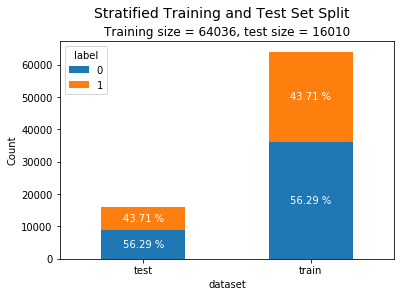

In [41]:
ax = pivot_df_split.plot(kind='bar', stacked=True, rot=0)
for i, p in enumerate(ax.patches):
    width, height = p.get_width(), p.get_height()
    _x, _y = p.get_xy() 
    size = len(y_test) if i % 2 == 0 else len(y_train)
    ax.text(_x+width/2, 
            _y+height/2, 
            '{:.2f} %'.format(100*(height/size)), 
            color='w',
            horizontalalignment='center', 
            verticalalignment='center')

_ = plt.suptitle('Stratified Training and Test Set Split', fontsize=14, y=1)
_ = plt.title('Training size = %d, test size = %d' % (len(y_train), len(y_test)))
_ = plt.ylabel('Count')
plt.savefig(IMG_PATH + '1.4.1.png')

# 2. Modeling
- Preprocessing: 
    - There is no need to preprocess the categorical feature `is_homepage` as it's already one-hot-encoded.
    - Neither do we need to impute missing values as the data is complete.
    - Scale the numerical features. 
        - This can speed up gradient descent as in XGBoost. 
        - Scaling is also essential for distance-based algorithms, e.g., SVM.
        - Experiment with StandardScaler and RobustScaler
- Dealing with class imbalance
    - Challenge for imbalanced dataset: classifier algorithms such as Decision Tree and Logistic Regression have a **bias towards majority classes**: they tend to predict the majority class, while the features of the minority class are prone to be treated as noise. This can lead to a higher probability of misclassification of the minority class as compared to the majority class.
    - Solution: 
        - Data: experiment with two remedies
            - Class weight
            - SMOTE
        - Evaluation metric: ROC AUC
            - F1, Precision and recall are included for business insights, e.g., if we want our model to detect more correct positive samples.
        - Model: Bagging/Boosting-based techniques should be better, e.g., Random Forest/Gradient Boosting.

In [42]:
def get_val_scores(fit_results, model_name, cv=10, is_tuned=False):
    """
    Computes validation scores in cross-validation/grid Search.
    """
    
    score_ls = []
    
    if not is_tuned: 
        for metric in ['roc_auc', 'f1', 'precision', 'recall']:
            for split in range(cv):
                key = '_'.join(['test', metric])
                score_ls.append([model_name, metric, split, fit_results[key][split]])
    else:
        results = fit_results.cv_results_
        best_params_idx = results['params'].index(fit_results.best_params_)

        for metric in ['roc_auc', 'f1', 'precision', 'recall']:
            for split in range(cv):
                score_key = '_'.join(['split'+str(split), 'test', metric])
                score_ls.append([model_name, metric, split, results[score_key][best_params_idx]])
    
    score_df = pd.DataFrame(score_ls, 
                            columns=['classifier', 'metric', 'split', 'val_score'])
    
    mean_score = score_df[score_df['classifier'] == model_name].groupby('metric')['val_score'].mean()
    mean_score = mean_score.reset_index().rename(
        {'val_score': 'mean_val_score'}).sort_values(by='metric', ascending=False)
    
    print('Validation Scores:\n', mean_score)
    return score_df

In [68]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from timeit import default_timer

def fit_model(X_train, y_train, model, preprocess=True,
              scale='robust',imbalance='class_weight',
              cv=10, tuning=None, n_iter=10, params=None):
    """
    Fits a classifier and returns the fitted classifier, validation 
    scores and execution time.
    """
    start_time = default_timer()
    clf_name = model.__class__.__name__
    # Record time complexity for each classifier
    time = pd.DataFrame(columns=['classifier', 'time'])
    
    pipe = model
    
    if preprocess:
        # 1. preprocess: scale numercial values
        numerical = list(X_train.columns)
        if 'is_homepage' in numerical:
            numerical.remove('is_homepage')
        if scale == 'standard': 
            scaler = StandardScaler()
        if scale == 'robust':
            scaler = RobustScaler()

        preprocess = make_column_transformer(
            (scaler, numerical), 
            remainder='passthrough'
        )
    
        # 2. dealing with imbalance: smote/class weight
        if imbalance == 'class_weight':
            pipe = make_imb_pipeline(preprocess, model)

        if imbalance == 'smote':
            pipe = make_imb_pipeline(preprocess, 
                                     SMOTE(random_state=SEED),
                                     model)

    # 3.1. tuning hyperparameters: grid search/random search
    if tuning:
        if tuning == 'grid':
            grid = GridSearchCV(pipe, params, return_train_score=True,
                                scoring=('roc_auc', 'f1', 
                                         'precision', 'recall'), 
                                refit='roc_auc', cv=cv, n_jobs=-1)
        if tuning == 'random':
            # Use RandomSearchCV for efficiency. Randomly choose n_iter settings.
            grid = RandomizedSearchCV(pipe, params, return_train_score=True, 
                                      n_iter=n_iter, random_state=SEED,
                                      scoring=('roc_auc', 'f1', 
                                               'precision', 'recall'), 
                                      refit='roc_auc', cv=cv, n_jobs=-1)    
        grid.fit(X_train, y_train)
        print('Best parameters:', grid.best_params_)
        scores = get_val_scores(grid, clf_name, is_tuned=True)
        
        elapsed = round(default_timer() - start_time, 2)
        time = time.append({'classifier': clf_name, 'time': elapsed} , ignore_index=True)
        print('Execution Time: %.2f s' % elapsed)
        return grid, scores, time
    
    # 3.2. default: no tuning -> cross validation
    results = cross_validate(pipe, X_train, y_train, cv=cv, 
                             scoring=('roc_auc', 'f1', 'precision', 'recall'))
    scores = get_val_scores(results, clf_name)

    pipe.fit(X_train, y_train)
    
    elapsed = round(default_timer() - start_time, 2)
    time = time.append({'classifier': clf_name, 'time': elapsed} , ignore_index=True)
    print('\nExecution Time: %.2f s' % elapsed)
    return pipe, scores, time

## 2.1 Baselines 
### 2.1.1 Linear
#### 2.1.1.1 Logistic Regression
- We will start with the simple logistic regression model with no preprocessing.

In [44]:
from sklearn.linear_model import LogisticRegression
lr_raw, lr_raw_scores, lr_raw_time = fit_model(X_train, 
                                               y_train,
                                               LogisticRegression(), 
                                               False)

Validation Scores:
       metric  val_score
3    roc_auc   0.559197
2     recall   0.211118
1  precision   0.656845
0         f1   0.309805

Execution Time: 5.55 s


- Now, add preprocessing and experiment with different preprocessing methods.

In [45]:
lr_sm, lr_sm_scores, lr_sm_time = fit_model(X_train, y_train, 
                                            LogisticRegression(), 
                                            scale='standard',
                                            imbalance='smote')

Validation Scores:
       metric  val_score
3    roc_auc   0.696076
2     recall   0.609275
1  precision   0.591226
0         f1   0.600091

Execution Time: 54.37 s


In [46]:
lr_cw, lr_cw_scores, lr_cw_time = fit_model(X_train, y_train, 
                                            LogisticRegression(class_weight='balanced'),
                                            scale='standard',
                                            imbalance='class_weight')

Validation Scores:
       metric  val_score
3    roc_auc   0.696140
2     recall   0.609132
1  precision   0.591518
0         f1   0.600169

Execution Time: 2.09 s


In [47]:
lr_rb, lr_rb_scores, lr_rb_time = fit_model(X_train, y_train, 
                                            LogisticRegression(class_weight='balanced'),
                                            scale='robust', 
                                            imbalance='class_weight')

Validation Scores:
       metric  val_score
3    roc_auc   0.696141
2     recall   0.609061
1  precision   0.591407
0         f1   0.600079

Execution Time: 7.16 s


- **We will use class weight instead of SMOTE for advanced models.** Though model performance is very close for the two methods, class weight is way more computationally efficient than oversampling methods such as SMOTE.
- **We will use RobustScaler instead of StandardScaler for advanced models.** This accounts for outliers in our dataset.

In [48]:
lr_rb, lr_rb_scores, lr_rb_time = fit_model(X_train, y_train, 
                                            LogisticRegression(class_weight='balanced'),
                                            scale='robust', 
                                            imbalance='class_weight')

Validation Scores:
       metric  val_score
3    roc_auc   0.696141
2     recall   0.609061
1  precision   0.591407
0         f1   0.600079

Execution Time: 7.15 s


#### 2.1.1.2 (Linear) SVC
- A note on non-linear kernels
    - Time complexity: the runtime for a non-linear kernel is roughly $O(n_{samples}^2 * n_{features})$. Since we have 64000 data points along with 10 features, a non-linear kernel can explode runtime, let alone the time complexity introduced by cross-validation or grid search. Thus, we will not experiment with nonlinear SVC.

In [49]:
from sklearn.svm import LinearSVC

lsvc, lsvc_scores, lsvc_time = fit_model(X_train, y_train, 
                                         LinearSVC(class_weight='balanced', 
                                                   random_state=SEED))

Validation Scores:
       metric  val_score
3    roc_auc   0.695940
2     recall   0.596557
1  precision   0.595081
0         f1   0.595634

Execution Time: 79.36 s


- Performances of linear models are mediocre, suggesting that the data might not be linearly separable. We will experiment with some non-linear classifiers.

### 2.1.2 Non-linear
#### 2.1.2.1 KNN
- Class weight is not provided with the wrapper. We will use SMOTE instead.

In [50]:
from sklearn.neighbors import KNeighborsClassifier

knn, knn_scores, knn_time = fit_model(X_train, y_train,  
                                      KNeighborsClassifier(n_neighbors=15), 
                                      imbalance='smote')

Validation Scores:
       metric  val_score
3    roc_auc   0.672587
2     recall   0.615813
1  precision   0.562095
0         f1   0.587696

Execution Time: 72.98 s


#### 2.1.2.2 Decision Trees

In [51]:
from sklearn.tree import DecisionTreeClassifier

tree, tree_scores, tree_time = fit_model(X_train, y_train,  
                                         DecisionTreeClassifier(
                                             random_state=SEED, 
                                             class_weight='balanced'))

Validation Scores:
       metric  val_score
3    roc_auc   0.570472
2     recall   0.516953
1  precision   0.516348
0         f1   0.516613

Execution Time: 6.31 s


## 2.2 Ensembles
### 2.2.1 Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {'randomforestclassifier__max_depth': [int(x) for x in np.linspace(10, 100, 5)], 
             'randomforestclassifier__max_features': ['auto', 'sqrt'],
             'randomforestclassifier__n_estimators': [50, 100, 150, 200]}
rf, rf_scores, rf_time = fit_model(X_train, y_train,  
                                   RandomForestClassifier(random_state=SEED, 
                                                          class_weight='balanced'), 
                                   n_iter=20, tuning='random', params=rf_params)

Best parameters: {'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__max_depth': 10}
Validation Scores:
       metric  val_score
3    roc_auc   0.715073
2     recall   0.606096
1  precision   0.612988
0         f1   0.609490
Execution Time: 361.26 s


### 2.2.2 XGBoost

In [53]:
from xgboost import XGBClassifier

class_weight = np.sum(y_train == 0)/np.sum(y_train == 1)
xgb_params = {'xgbclassifier__max_depth': range(3, 8), 
              'xgbclassifier__learning_rate': [0.01, 0.05, 0.1, 0.3], # learning rate
              'xgbclassifier__gamma': range(0, 16, 5)} # regularization
xgb, xgb_scores, xgb_time = fit_model(X_train, y_train,  
                                      XGBClassifier(random_state=SEED, 
                                                    scale_pos_weight=class_weight), 
                                      n_iter=20, tuning='random', params=xgb_params)

Best parameters: {'xgbclassifier__max_depth': 6, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__gamma': 10}
Validation Scores:
       metric  val_score
3    roc_auc   0.716682
2     recall   0.616064
1  precision   0.611434
0         f1   0.613682
Execution Time: 125.19 s


## 2.3 Comparison

In [54]:
scores = pd.concat([lr_rb_scores, \
                    lsvc_scores, knn_scores, \
                    tree_scores, rf_scores, xgb_scores])

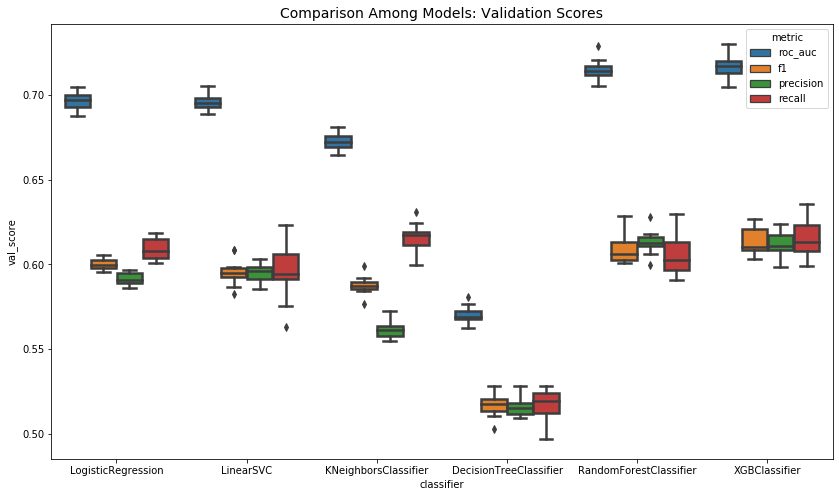

In [55]:
_ = plt.figure(figsize=(14, 8))
_ = sns.boxplot(x='classifier', y='val_score', hue='metric', data=scores, linewidth=2.5) 
_ = plt.title('Comparison Among Models: Validation Scores', fontsize=14)
plt.savefig(IMG_PATH + '2.3.1.png')

In [56]:
time = pd.concat([lr_cw_time, lsvc_time, knn_time, tree_time, rf_time, xgb_time])

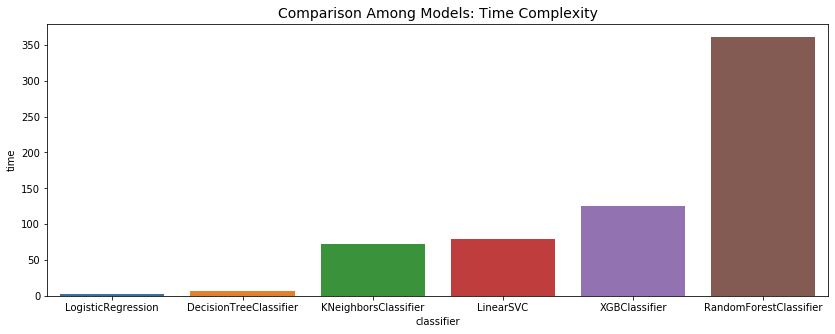

In [57]:
_ = plt.figure(figsize=(14, 5))
sns.barplot(x='classifier', y='time', data=time.sort_values(by='time'))
_ = plt.title('Comparison Among Models: Time Complexity', fontsize=14)
plt.savefig(IMG_PATH + '2.3.2.png')

- Model evaluation
    - Performance
        - Ensemble classifiers such as XGBoost and Random Forest have higher validation scores.
        - All models except Random Forest have higher recall than precision.
        - Validation scores for simple linear models are close to those of ensembles.  
    - Time complexity
        - Logistic Regression and Decision Tree are the fastest among the untuned models.
        - XGBoost is way faster than Random Forest.
- Overall, we will choose XGBoost as the best model. Additionally, we will forward the logistic regression model to the next step for its overall performance and simplicity.

## 2.4 Model Validation
### 2.4.1 Test Performance

In [94]:
from sklearn.metrics import roc_auc_score, classification_report, plot_confusion_matrix

def test_score(X_test, y_test, model, imbalance='class_weight', is_tuned=False):
    
    if is_tuned:
        model = model.best_estimator_
    
    classifier = model.steps[1][1] if imbalance == 'class_weight' else model.steps[2][1]
    clf_name = model.steps[1][0] if imbalance == 'class_weight' else model.steps[2][0]
    
    y_pred = model.predict(X_test)
    
    test_roc = roc_auc_score(y_test, y_pred)
    
    print('Classification report for classifier \n%s:\n%s\n'
      % (classifier, classification_report(y_test, y_pred)))
       
    test_roc_auc = roc_auc_score(y_test, y_pred)
    print('Test ROC-AUC: %f\n' % test_roc_auc)
          
    disp = plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
    disp.figure_.suptitle('Confusion Matrix for Test Data', fontsize=14)
    print('Confusion matrix:\n%s' % disp.confusion_matrix)
    plt.savefig(IMG_PATH + clf_name + '_test.png')
    
    return test_roc_auc

Classification report for classifier 
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=10, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1.287898817392547, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None):
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      9012
           1       0.61      0.60      0.60      6998

    accuracy                           0.65     16010
   macro avg       0.65      0.65      0.65     16010
weighted avg       0.65      0.65      0.65     16010



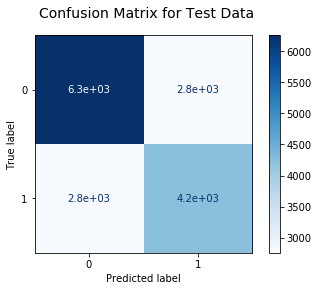

In [95]:
xgb_test_score = test_score(X_test, y_test, xgb, is_tuned=True)

### 2.4.2 Feature Importance

In [96]:
def plot_feature_imp(features, model, model_type, is_tuned=True):
    if is_tuned:
        model = model.best_estimator_

    clf_name = model.steps[1][0]
    
    # Collect feature names: move is_homepage to the end if it is present
    if 'is_homepage' in features:
        features.remove('is_homepage')
        features.append('is_homepage') 

    # Collect feature importances/coefficients
    if model_type == 'tree':
        coef = model.steps[1][1].feature_importances_
    if model_type == 'linear':
        coef = model.steps[1][1].coef_[0]
    
    # Sort features according to coefficients (descendingly)
    features = [f for _, f in sorted(zip(coef, features), reverse=True)]
    colors = ['tab:blue' if c > 0 else 'tab:red' for c in np.sort(coef)[::-1]]
    
    _ = plt.figure(figsize=(12, 6))
    _ = plt.bar(features, height=np.sort(coef)[::-1], color=colors)
    _ = plt.xlabel('Features')
    if model_type == 'tree':
        _ = plt.ylabel('Feature Importance')
    if model_type == 'linear':
        _ = plt.ylabel('Coefficients')
    _ = plt.title('Classifier: ' + model.steps[1][0], fontsize=14)
    
    plt.savefig(IMG_PATH + clf_name + '_feature_imp.png')

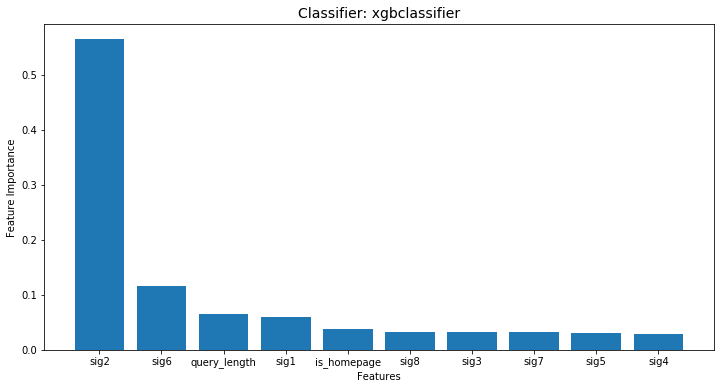

In [97]:
plot_feature_imp(list(X_train.columns), xgb, 'tree')

# 4. Recommendation
## 4.1 An explainable model

In [98]:
lr_params = {'logisticregression__C': np.logspace(-2, 1, 4)} 

X_train_selected = X_train[['sig2', 'sig6', 'query_length', 'sig1', 'is_homepage', 'sig8']]

lr, lr_scores, lr_time = fit_model(X_train_selected, y_train, 
                                   LogisticRegression(class_weight='balanced'),
                                   scale='robust', 
                                   imbalance='class_weight',
                                   tuning='grid', params=lr_params)

Best parameters: {'logisticregression__C': 0.01}
Validation Scores:
       metric  val_score
3    roc_auc   0.692643
2     recall   0.604523
1  precision   0.587739
0         f1   0.595995
Execution Time: 2.51 s


Classification report for classifier 
LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False):
              precision    recall  f1-score   support

           0       0.68      0.67      0.67      9012
           1       0.58      0.59      0.59      6998

    accuracy                           0.64     16010
   macro avg       0.63      0.63      0.63     16010
weighted avg       0.64      0.64      0.64     16010


Test ROC-AUC: 0.631148

Confusion matrix:
[[6016 2996]
 [2836 4162]]


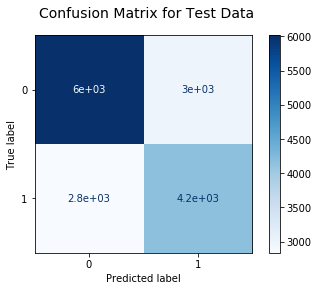

In [99]:
X_test_selected = X_test[['sig2', 'sig6', 'query_length', 'sig1', 'is_homepage', 'sig8']]
lr_test_score = test_score(X_test_selected, y_test, lr, is_tuned=True)

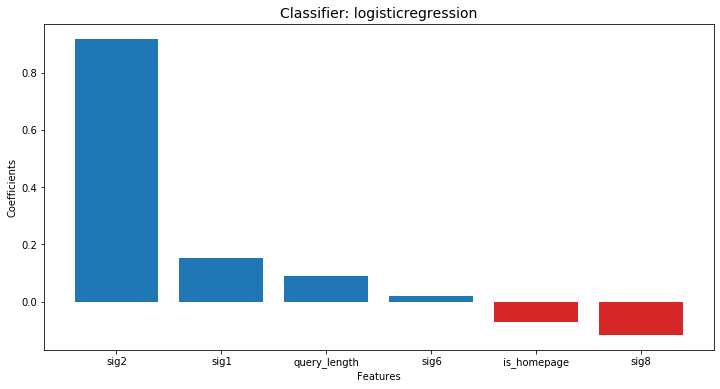

In [100]:
plot_feature_imp(list(X_train_selected.columns), lr, 'linear')

## 4.2 Business Insights

In [112]:
from sklearn.metrics import precision_recall_curve

def plot_pr_curve(X_test, y_test, model, is_tuned=True):
    if is_tuned:
        model = model.best_estimator_
    
    y_pred = model.predict_proba(X_test)[:, 1]  
    precision_ls, recall_ls, thresholds_ls = precision_recall_curve(y_test, y_pred)
    
    # Add the last point to the threshold list end
    thresholds_ls = np.append(thresholds_ls, 1) 

    rel_rate_ls = []
    for t in thresholds_ls:  
        # estimate how many predictions would be made as positive for a given threshold
        rel_rate_ls.append((y_pred >= t).mean()) 
    _ = plt.figure(figsize=(10, 5))
    _ = plt.plot(thresholds_ls, precision_ls, 
                 color=sns.color_palette()[0])
    _ = plt.plot(thresholds_ls, recall_ls, 
                 color=sns.color_palette()[1]) 
    _ = plt.plot(thresholds_ls, rel_rate_ls, 
                 color=sns.color_palette()[2]) 
    _ = plt.xlabel('Threshold')  
    _ = plt.ylabel('Proportion') 
    _ = plt.title('Precision-Recall-Relevance Rate', fontsize=14)
    legend = plt.legend(('Precision', 'Recall', 'Relevance Rate'), frameon=True, loc='best') 
    legend.get_frame().set_edgecolor('k')  

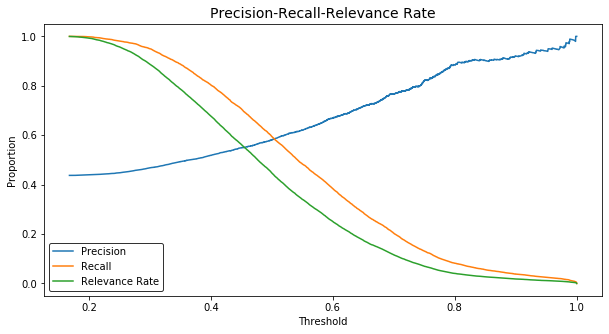

In [113]:
plot_pr_curve(X_test_selected, y_test, lr)